Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=546.822, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1474.970, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=547.587, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=564.030, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=534.788, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=535.395, Time=0.17 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=536.718, Time=0.26 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=545.048, Time=0.33 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=536.707, Time=0.25 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=518.227, Time=0.51 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=536.241, Time=0.47 s

c:\Users\birdl\anaconda3\envs\course02502\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
c:\Users\birdl\anaconda3\envs\course02502\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
c:\Users\birdl\anaconda3\envs\course02502\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
c:\Users\birdl\anaconda3\envs\course02502\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


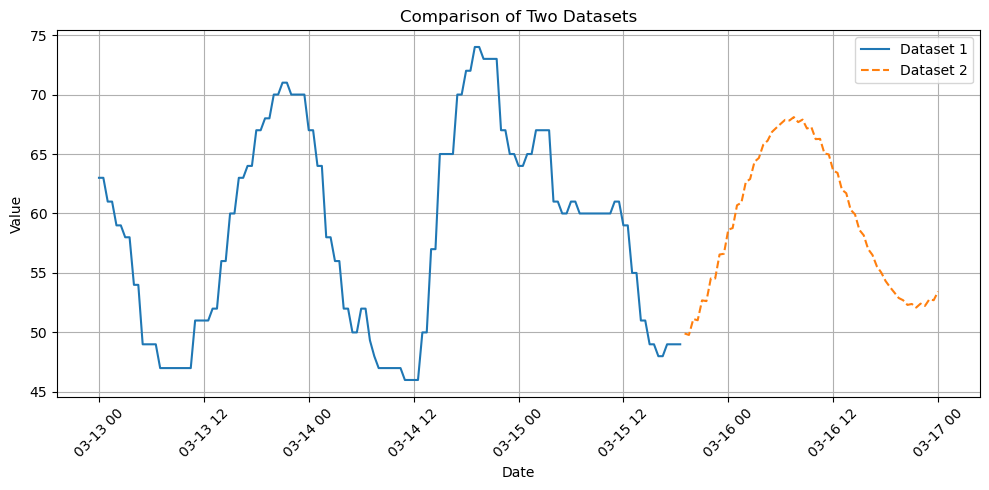

In [4]:
from sklearn import linear_model as lm
import numpy as np
import datetime as dt
from DataGeneration import DataGeneration
from sensors.sensor import Sensor
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from pmdarima import auto_arima
from sensors.Cleanser import cleanser


#Create a class that will predict future values of a sensor
#The class will take in a sensor object and a prediction end date
#The class will calculate the prediction intervals and the prediction start date from the sensor object values


class DataPrediction:
    def __init__(self, sensor, prediction_end_date, model_name):
        
        self.X = list(sensor.value.keys())
        self.prediction_intervals = self.X[-1] - self.X[-2]
        self.prediction_start_date = self.X[-1] + self.prediction_intervals
        self.prediction_end_date = prediction_end_date

        self.Y = list(sensor.value.values())

        self.X_future = None
        self.forcasted_values = sensor.forcasted_values

        self.model = None

    
    def set_prediction_timeframe(self):

        current_date = self.prediction_start_date

        future_dates = [current_date]

        while current_date + self.prediction_intervals <= self.prediction_end_date:
            current_date += self.prediction_intervals
            future_dates.append(current_date)

        self.X_future = future_dates

    def predict(self):

        predictions = self.model.forecast(steps=len(self.X_future))

        self.forcasted_values = predictions.to_list()

    def train_model(self):

        df = pd.DataFrame(data=self.Y, index=self.X, columns=['Value'])

        auto_arima_model = auto_arima(df, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_order=None, trace=True)

        best_order = auto_arima_model.order

        model = ARIMA(df, order=best_order)
        fitted_model = model.fit()

        self.model = fitted_model

    def convert_prediction_to_dict(self):
        self.forcasted_values = dict(zip(self.X_future, self.forcasted_values))


time_series = DataGeneration(9, 30, 1, '2024-03-13 00:00:00').get_time_series()

sensor = Sensor(1, 'Temperature Sensor', 'A sensor that measures temperature', 'float', time_series)

cleansed = cleanser(sensor, 1)

data = cleansed.replace_missing_values()

for key, new_value in zip(cleansed.sensor.value.keys(), data):
    cleansed.sensor.value[key] = new_value

data = cleansed.set_data_types_to_float()

for key, new_value in zip(cleansed.sensor.value.keys(), data):
    cleansed.sensor.value[key] = new_value

predict = DataPrediction(sensor, dt.datetime(2024, 3, 17, 0, 0, 0), 'linear_regression')

predict.set_prediction_timeframe()
predict.train_model()
predict.predict()
predict.convert_prediction_to_dict()

dates1 = list(sensor.value.keys())
dates2 = list(predict.forcasted_values.keys())

values1 = list(sensor.value.values())

for i in range(0,len(values1)):
    if values1[i] == None:
        values1[i] = (float(values1[i-1])+float(values1[i+1]))/2

values2 = list(predict.forcasted_values.values())
             

plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.plot(dates1, values1, label='Dataset 1')  # Plot the first dataset
plt.plot(dates2, values2, label='Dataset 2', linestyle='--')  # Plot the second dataset with a different style

# Formatting the plot
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Value')  # Set y-axis label
plt.title('Comparison of Two Datasets')  # Set title
plt.legend()  # Show legend to differentiate the datasets
plt.grid(True)  # Show grid for better readability
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

plt.show() 

c:\Users\birdl\anaconda3\envs\course02502\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


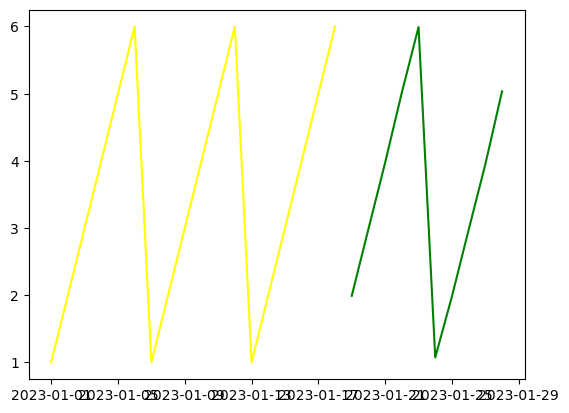

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

# Define the start date for date1 array
start_date = dt.datetime(2023, 1, 1)  # Example: starting from January 1, 2023

# Create date1 array with 18 days of datetime objects starting from start_date
date1 = [start_date + dt.timedelta(days=i) for i in range(18)]

# The start date for date2 is one day after the last date in date1
start_date2 = date1[-1] + dt.timedelta(days=1)

# Create date2 array with 20 days of datetime objects starting from start_date2
date2 = [start_date2 + dt.timedelta(days=i) for i in range(10)]

y = [1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6]

ARIMAmodel = SARIMAX(y, order=(5,1,0))

ARMAmodel = ARIMAmodel.fit()

y_pred = ARMAmodel.get_forecast(10)

predictions = ARMAmodel.predict(start = 19, end = 28)

plt.plot(date1,y, color='Yellow', label = 'ARIMA Predictions')
plt.plot(date2,predictions, color='green', label = 'ARIMA Predictions')


In [6]:
import datetime as dt
import pandas as pd
start_date = dt.datetime(2023, 1, 1)
date_range = pd.date_range(start_date, periods=38)
print(type(date_range))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
